In [1]:
# Si colocamos '!' delante de una linea se indica que esa línea se ejecutará como en una consola bash de la instancia de Compute Engine 
# sobre la que estamos ejecutando Datalab

# Con este comando vemos los paquetes Python instalados. Podemos apreciar que hay un gran número de paquetes preinstalados
!pip freeze

appdirs==1.4.3
avro==1.8.1
backports-abc==0.5
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.5.3
bleach==2.0.0
brewer2mpl==1.4.1
bs4==0.0.1
cachetools==2.0.0
certifi==2017.4.17
configparser==3.5.0
crcmod==1.7
cycler==0.10.0
datalab==1.0.1
decorator==4.0.11
dill==0.2.6
entrypoints==0.2.2
enum34==1.1.6
funcsigs==1.0.2
functools32==3.2.3.post2
future==0.16.0
futures==3.0.5
gapic-google-logging-v2==0.9.3
gapic-google-pubsub-v1==0.9.3
ggplot==0.6.8
google-api-python-client==1.5.1
google-apitools==0.5.9
google-auth==1.0.0
google-auth-httplib2==0.0.2
google-cloud==0.19.0
google-cloud-bigquery==0.22.1
google-cloud-core==0.22.1
google-cloud-dataflow==0.6.0
google-gax==0.13.0
googleapis-common-protos==1.5.2
googledatastore==7.0.0
grpc-google-logging-v2==0.9.3
grpc-google-pubsub-v1==0.9.3
grpcio==1.2.1
html5lib==0.999999999
httplib2==0.9.2
ipykernel==4.5.2
ipython==5.3.0
ipython-genutils==0.2.0
ipywidgets==6.0.0
Jinja2==2.8
jsonschema==2.6.0
jupyter-client==5.0.1
jupyter-core==4.3.0


In [ ]:
# Con los dos símbolos '%%' y la palabra clave bash, se indica que toda la celda (y no solo la línea, como ocurría con '!')
# se ejecutará como si fueran comandos bash
# Por ejemplo, con estos comandos actualizaríamos los paquetes de python scikit-learn y tensorflow (en este notebook utilizaremos TensorFlow 1.1.0)
# Reiniciar el kernal (botón de Reset Session) tras ejecutar la celda siguiente

In [ ]:
%%bash 
pip install sklearn --upgrade
pip install tensorflow==1.1.0

In [ ]:
# La documentación sobre el dataset público de los viajes en taxi en Chicago se encuentra en: https://cloud.google.com/bigquery/public-data/chicago-taxi
# Más información en: http://digital.cityofchicago.org/index.php/chicago-taxi-data-released

# Detalles del dataset (https://bigquery.cloud.google.com/dataset/bigquery-public-data:chicago_taxi_trips) a fecha de 11 de julio de 2017

# Tamaño tabla: 34.1 GB
# ID tabla: bigquery-public-data:chicago_taxi_trips.taxi_trips
# Número de filas: 99,761,096
# Número de columnas: 23


In [ ]:
"""
Ejemplo 1: llamada a la API de BQ 
Idea extraída de https://cloud.google.com/bigquery/docs/visualize-datalab
Realizaremos operaciones de preprocesamiento con Pandas y plotearemos un gráfico final con el número de viajes realizados en el mes de octubre
"""

In [2]:
import google.datalab.bigquery as bq

# Aprovechando que los tiempos de los viajes se guardan en intervalos de 15 minutos, 
# realizamos una query con el número de viajes en cada uno de esos intervalos

# La query se pasa como un string
query_string = 'SELECT trip_start_timestamp AS timestamp, COUNT(trip_start_timestamp) AS num_trips FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` GROUP BY timestamp ORDER BY timestamp ASC'
query = bq.Query(query_string)

# Pasamos a un dataframe de Pandas (la librería se importa automáticamente) el resultado de la query
df = query.execute(output_options=bq.QueryOutput.dataframe()).result()

# Vemos las 10 primeras filas del dataframe
df.head(10)

,timestamp,num_trips
0,2013-01-01 00:00:00,573
1,2013-01-01 00:15:00,1368
2,2013-01-01 00:30:00,1486
3,2013-01-01 00:45:00,1294
4,2013-01-01 01:00:00,1235
5,2013-01-01 01:15:00,1574
6,2013-01-01 01:30:00,1912
7,2013-01-01 01:45:00,1948
8,2013-01-01 02:00:00,1945
9,2013-01-01 02:15:00,1889


In [3]:
# Nos quedamos con los viajes realizados en octubre de 2016 utilizando Pandas

df['timestamp_year'] = df['timestamp'].dt.year
df['timestamp_month'] = df['timestamp'].dt.month
df['timestamp_hour'] = df['timestamp'].dt.hour
df = df.loc[df['timestamp_year'] == 2016]
df = df.loc[df['timestamp_month'] == 10]
df = df.drop('timestamp_year', axis=1)
df = df.drop('timestamp_month', axis=1)
df = df.drop('timestamp', axis=1)

# Reordenamos columnas (fuente: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [4]:
# Volvemos a agregar datos por hora, dado que ahora los teniamos
# divididos en intervalos de 15 minutos (fuente: http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)
df = df.groupby('timestamp_hour', as_index=False).agg({"num_trips": "sum"})

In [5]:
# Comprobamos que la tabla es correcta
df.head(10)

,timestamp_hour,num_trips
0,0,53279
1,1,42413
2,2,33453
3,3,24753
4,4,17214
5,5,14140
6,6,18545
7,7,35662
8,8,59722
9,9,70911


In [6]:
# Veamos una serie de estadísticas básicas sobre la tabla obtenida
df.describe()

,timestamp_hour,num_trips
count,24.000000,24.000000
mean,11.500000,62528.916667
std,7.071068,26674.884581
min,0.000000,14140.000000
25%,5.750000,40725.250000
50%,11.500000,69583.500000
75%,17.250000,80661.250000
max,23.000000,101489.000000


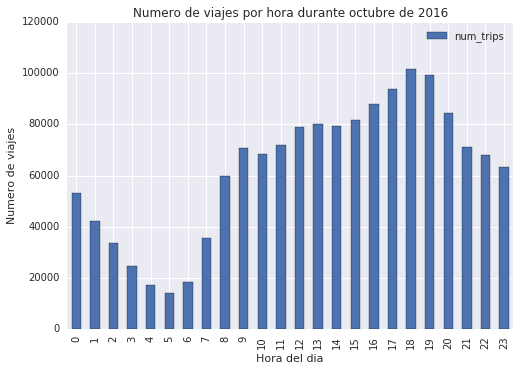

In [7]:
# Ploteamos el resultado de la query con el método plot de Pandas
# Podemos observar como se ha realizado un gran número de viajes entre las 4 y las 8 de la tarde
ax = df.plot(kind='bar',x='timestamp_hour',title='Numero de viajes por hora durante octubre de 2016')
ax.set_xlabel('Hora del dia')
ax.set_ylabel('Numero de viajes')

In [ ]:
"""
Ejemplo 2: llamada con celda 'mágica' a BQ
En este ejemplo intentaremos predecir el precio del viaje en taxi en función de las coordenadas donde se recoge y se deja al cliente, 
la duración y la distancia del viaje.
"""

In [8]:
# En este ejemplo volvemos a utilizar Pandas, así como Matplotlib para realizar ploteos y Numpy

from __future__ import division

import google.datalab.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Realizamos una llamada a BigQuery en lo que se denomina 'celda mágica'
# Obtenemos varias columnas comprobando que no contengan valores nulos
# Tal y como se advierte en la memoria, trabajamos con una muestra que no supera los 300.000 datos. Esto se hace gracias a la claúsula LIMIT

In [9]:
%%bq query -n taxi_queries
SELECT trip_seconds, trip_miles, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_miles IS NOT NULL AND
      trip_seconds IS NOT NULL AND
      pickup_latitude IS NOT NULL AND 
      pickup_longitude IS NOT NULL AND
      dropoff_latitude IS NOT NULL AND
      dropoff_longitude IS NOT NULL AND  
      fare IS NOT NULL
LIMIT 300000

In [10]:
# Ejecutamos la query y la volcamos en un Pandas dataframe 
# Gracias a BigQuery, el tiempo de ejecución de la query es menor al minuto a pesar de ser una tabla de 100 millones de filas.
df = taxi_queries.execute(output_options=bq.QueryOutput.dataframe()).result()

In [11]:
df.head(10)

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,720,3.21,41.920452,-87.679955,41.885281,-87.657233,9.85
1,120,0.60,41.920452,-87.679955,41.916005,-87.675095,4.45
2,900,0.20,41.920452,-87.679955,41.962179,-87.645379,12.45
3,2100,20.50,41.849247,-87.624135,41.979071,-87.903040,50.25
4,0,0.00,41.849247,-87.624135,41.849247,-87.624135,3.25
5,1380,5.20,41.849247,-87.624135,41.893216,-87.637844,15.25
6,1380,4.10,41.849247,-87.624135,41.893216,-87.637844,14.25
7,660,2.30,41.849247,-87.624135,41.877406,-87.621972,10.00
8,540,2.90,41.849247,-87.624135,41.890922,-87.618868,9.05
9,1560,3.90,41.849247,-87.624135,41.900221,-87.629105,14.65


In [12]:
# Normalización de columnas (normalizamos todo el dataset, por lo que si queremos utilizar más datos de esta tabla tendríamos que guardar la media y 
# la desviación típica, para así hacer entrenamientos con redes neuronales de forma correcta. En este caso hemos supuesto que esto no va a ocurrir)
cols_to_norm = ['pickup_latitude','pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

df.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,720,3.21,0.507829,-0.407624,-0.454571,-0.049205,9.85
1,120,0.60,0.507829,-0.407624,0.348448,-0.358583,4.45
2,900,0.20,0.507829,-0.407624,1.555261,0.156121,12.45
3,2100,20.50,-1.445325,0.481606,1.996765,-4.306708,50.25
4,0,0.00,-1.445325,0.481606,-1.396391,0.524069,3.25


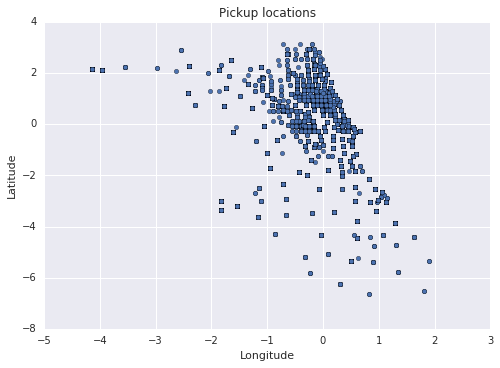

In [13]:
# Ploteamos en el plano los puntos de recogida (normalizados)
ax = df.plot(kind='scatter',x='pickup_longitude', y='pickup_latitude', title='Pickup locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

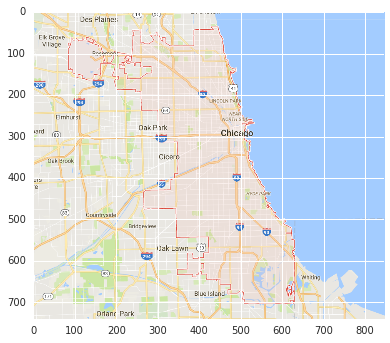

In [14]:
# En este mapa de la ciudad de Chicago vemos como los puntos de recogida y 'dropoff' se sitúan pegados a la línea costera

# Fuente: https://stackoverflow.com/questions/12116050/how-to-plot-remote-image-from-http-url
import urllib2
f = urllib2.urlopen("http://i.imgur.com/LMaPu6F.png")
a = plt.imread(f)
# Añadir format="jpg" para imágenes jpg
plt.imshow(a)
plt.show()


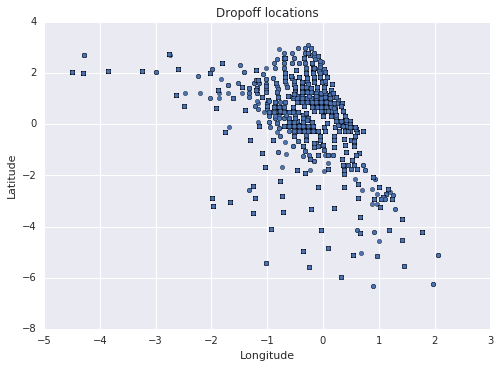

In [15]:
# Ploteamos en el plano los puntos donde se deja a los clientes (nótese como no hay gran diferencia con los puntos de recogida de clientes)

ax = df.plot(kind='scatter',x='dropoff_longitude', y='dropoff_latitude', title='Dropoff locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

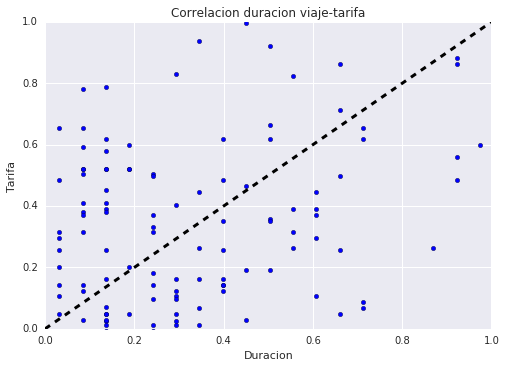

In [17]:
# Normalizamos los segundos, las millas y la tarifa de una muestra de datos para generar un gráfico 
# que nos permita observar si existe correlación entre la duración del viaje y la tarifa
# y la distancia recorrida en el viaje y la tarifa

df_cor = df.sample(1000).copy()
cols_to_norm = ['trip_seconds','trip_miles', 'fare']
df_cor[cols_to_norm] = df_cor[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

# Como era de esperar no existe una correlación entre la duración del viaje y la tarifa cobrada, puesto que normalmente se tarifa por
# distancia recorrida en el viaje
fig, ax = plt.subplots()
ax.scatter(df_cor['trip_seconds'].values, df_cor['fare'].values )
ax.plot([0, 1], [0, 1], 'k--', lw=3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Correlacion duracion viaje-tarifa')
ax.set_xlabel('Duracion')
ax.set_ylabel('Tarifa')
plt.show()

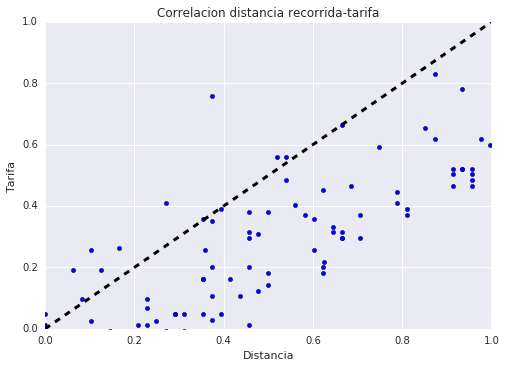

In [18]:
# En este caso si existe una correlación más clara entre la distancia recorrida y la tarifa, algo que concuerda
# con la lógica de los taxímetros
fig, ax = plt.subplots()
ax.scatter(df_cor['trip_miles'].values, df_cor['fare'].values )
ax.plot([0, 1], [0, 1], 'k--', lw=3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Correlacion distancia recorrida-tarifa')
ax.set_xlabel('Distancia')
ax.set_ylabel('Tarifa')
plt.show()

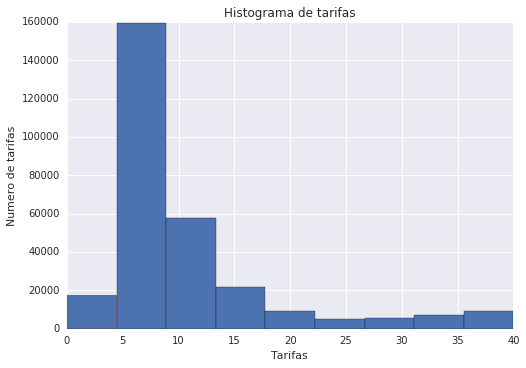

In [19]:
# Con este histograma podemos observar que hay un gran número de viajes cuya tarifa es entre 4 y 8 dólares
sep = np.linspace(start = 0, stop = 40, num = 10)
ax = df['fare'].hist(bins = sep)
ax.set_xlabel('Tarifas')
ax.set_ylabel('Numero de tarifas')
ax.set_title('Histograma de tarifas')

In [20]:
# Vamos a aplicar el algoritmo tsne de reducción de dimensionalidad (reduciendo de 6 a 2 las dimensiones, para así pintar los resultados en el plano)
# para comprobar 'cómo de distintos' son los viajes entre 4 y 8 dólares del resto

# Tomamos una muestra de 500 viajes en taxi
df_aux = df.sample(500).copy()

# Consideramos tarifas 'comunes' aquellas entre $4 y $8 y las indicamos con 1 en una columna. 0 en caso contrario
df_aux['normal_fare'] = df_aux['fare'].apply(lambda x: 1 if x >= 4 and x <= 8  else 0)
df_aux.drop('fare', axis=1, inplace=True)

# Nos quedamos con la columna de etiquetas que indican si la tarifa es 'común' o no
y = df_aux.ix[:,-1].values

df_aux.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,normal_fare
273721,540,1.9,0.544220,0.052653,1.060195,0.189165,1
83301,600,1.7,-0.098917,0.535330,-0.566615,0.374919,1
170933,120,0.0,-0.258671,0.448477,-0.462259,0.578497,1
249201,660,0.2,-0.258671,0.448477,0.879147,0.049013,0
251947,540,0.0,-0.456380,0.184134,-0.462259,0.578497,1


In [21]:
# La media de la columna que hemos creado nos permite saber el porcentaje de tarifas entre 4 y 8 dólares
df_aux['normal_fare'].describe()

count    500.000000
mean       0.474000
std        0.499824
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: normal_fare, dtype: float64

In [22]:
df_aux.drop('normal_fare', axis=1, inplace=True)

In [23]:
#Función para plotear tras aplicar tsne
def plot_data_2d(X, y, x_lims = None, y_lims = None):
  color_map = {0:'red', 1:'blue'}
  plt.figure()
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = X[y==cl,0], 
                y = X[y==cl,1], 
                c = color_map[idx], 
                label = cl)
  plt.xlabel('dimension 1 tras aplicar t-SNE')
  plt.ylabel('dimension 2 tras aplicar t-SNE')
  plt.legend(loc='upper left')
  plt.title('Algoritmo t-SNE ejecutado en el dataset de viajes de taxi en Chicago')
  if x_lims is not None and y_lims is not None:
    plt.xlim(x_lims)
    plt.ylim(y_lims)
  plt.show()
  

In [24]:
# Generamos el plot en dos dimensiones tras aplicar el alogritmo t-SNE del paquete de Scikit-learn
# Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


# Escalamos las variables para mejorar el tiempo de ejecución del algoritmo t-SNE
standard_scaler = StandardScaler()
df_std = standard_scaler.fit_transform(df_aux)

# Ejecutamos el algoritmo t-SNE (computacionalmente caro)
tsne = TSNE(n_components=2, random_state=0)
tsne_2d = tsne.fit_transform(df_std)

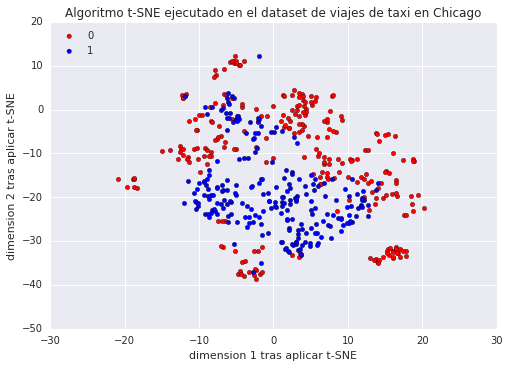

In [25]:
# Construimos un gráfico con los puntos obtenidos al aplicar t-SNE
# Con este resultado vemos que reduciendo las dimensiones a 2, existe una relativa separación entre las tarifas 'comunes' y el resto
# aunque necesitaríamos seguir realizando un análisis y limpiado de datos antes de aplicar el algoritmo t-SNE para obtener una separación
# aún más clara
plot_data_2d(tsne_2d, y)

In [ ]:
# Parece que en ocasiones hay problemas al encontrar la función de split que se usa un par de celdas más adelante
# Para solucionarlo se requiere que el paquete Scikit-learn esté correctamente actualizado.
# En caso de seguir fallando, reiniciar el kernel de Datlab por medio del botón 'Reset Session'

In [26]:
# Pasamos ahora a la parte de entrenamiento con redes neuronales
# En primer lugar dividimos el dataset en datos de entrenamiento, validación y test gracias a otra función de Scikit-learn
from sklearn.model_selection import train_test_split

# Porcentajes de entrenamiento, validación y test (¡deben sumar 1 entre los tres!)
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

# Pasamos el dataframe de Pandas a un array de Numpy
dataset = df.as_matrix()

# Realizamos la división en los tres conjuntos, obteniendo la matriz de variables por un lado y la columna con las tarifas en la otra
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:-1], dataset[:,-1], test_size=TEST_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_SIZE/TRAIN_SIZE)

In [27]:
# Dado que Keras se encuentra dentro del paquete 'contrib' de TensorFlow no necesitamos realizar el import de todo TensorFlow
#import tensorflow as tf

import sys
import os


In [28]:
# Importamos las funcionalidades de Keras desde dentro del paquete 'contrib' de TensorFlow
# He comprobado que en ocasiones esta importación no se realiza correctamente por lo que he abierto un issue 
# en https://stackoverflow.com/questions/45032891/cannot-import-keras-from-tensorflow-contrib-package-in-datalab
# Actualización: Creo haber detectado el error y he propuesto una solución para este problema en el enlace anterior.
from tensorflow.contrib import keras
from tensorflow.contrib.keras.python.keras.regularizers import l1,l2
from tensorflow.contrib.keras.python.keras.models import Sequential, load_model
from tensorflow.contrib.keras.python.keras.layers import Dense, Dropout, Activation
from tensorflow.contrib.keras.python.keras.constraints import max_norm
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adam
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

# Eliminamos los warnings de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [ ]:
# Podemos por otro lado, si no funciona el método anterior, instalar keras como un paquete separado e importarlo

In [ ]:
!pip install keras

In [50]:
import keras
from keras.regularizers import l1,l2
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.constraints import max_norm
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization

# Eliminamos los warnings de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [29]:
# Volvemos a limitar el dataset resultante de la query
LIMIT = 100000

# Limitamos los ejemplos de entrenamiento a viajes que cuesten menos de 20$
mask_train = Y_train < 20
mask_val = Y_val < 20
mask_test = Y_test < 20


X_train = X_train[mask_train]
Y_train = Y_train[mask_train]
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]

# Limitamos los tamaños de los tres conjuntos de datos
TRAIN_LIMIT = int(LIMIT*TRAIN_SIZE)
VAL_LIMIT = int(LIMIT*VAL_SIZE)
TEST_LIMIT = int(LIMIT*TEST_SIZE)

x_train = X_train[:TRAIN_LIMIT]
y_train = Y_train[:TRAIN_LIMIT]
x_val = X_val[:VAL_LIMIT]
y_val = Y_val[:VAL_LIMIT]
x_test = X_test[:TEST_LIMIT]
y_test = Y_test[:TEST_LIMIT]

In [30]:
# Esta es la parte de entrenamiento de redes neuronales. Simplemente cambiando hiperparámetros y reejecutando la celda,
# vamos obteniendo distintos modelos

# Estas tres variables son hiperaparámetros (hyperparameters) de la red neuronal
batch_size = 500
epochs = 100
dropout_rate = 0.5

# Tenemos 6 neuronas de entrada (no contamos la última columna con las tarifas, pues es la que intentamos predecir)
input_dim = dataset.shape[1] - 1

# Creamos una red neuronal. Nótese la facilidad para añadir y eliminar capas ocultas, así como el número de neuronas en cada capa
# y optimizaciones como inicializaciones de pesos, dropouts o batch normalization
model = Sequential()
model.add(Dense(5,input_shape=(input_dim,), kernel_initializer='he_normal'))

# Antes de cada capa oculta aplicamos batch normalization, la función de activación de la capa anterior
# el dropout y por último añadimos las neuronas que forma esta capa oculta
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(4))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(4))


model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(3))


model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(2))


# La capa de salida tiene una neurona, la cual predice el coste del viaje en taxi.
# Al ser un problema de regresión, no aplicamos la función softmax a la última capa
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

# Mostramos en pantalla un resumen de las capas y los parámetros de la red
model.summary()

# Podemos utilizar varios optimizadores para el algoritmo de descenso de gradiente, como Adam o RMSprop()
# Más información en: https://keras.io/optimizers/
#opt = Adam()
opt = RMSprop()

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=[keras.metrics.mean_absolute_error, keras.metrics.mean_absolute_percentage_error])

# Entrenamos el modelo (con verbose 0 apagamos el log y con 1 se muestra con barra de progreso)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_val, y_val))


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss (mse):', score[0])
print('Test mae:', score[1])
print('Test mape:', score[2])

y_pred = model.predict_proba(x_test, verbose = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5)                 20        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 24        
_________________________________________________________________
batch_normalization_2 (Batch (None, 4)                 16        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
__________

/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/keras/python/keras/models.py:960: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


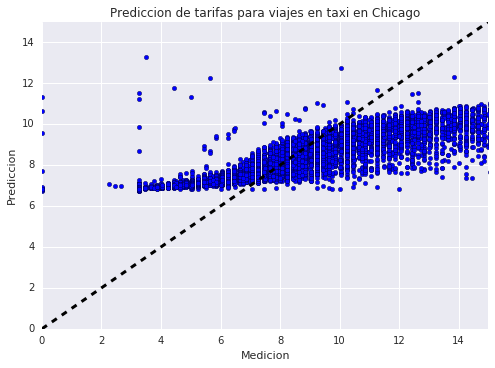

In [31]:
# Ploteamos en un gráfico las predicciones realizadas por nuestro modelo en el eje de ordenadas frente a los valores reales 
# de las tarifas en el eje de abcisas. Cuanto más alejados estén los puntos de la línea discontinua, las predicciones serán cada vez menos precisas 
import matplotlib.pyplot as plt

PLOT_LIM = 15
fig, ax = plt.subplots()
ax.scatter(y_test[:TEST_LIMIT], y_pred[:TEST_LIMIT] )
ax.plot([0, PLOT_LIM], [0, PLOT_LIM], 'k--', lw=3)
ax.set_xlim([0, PLOT_LIM])
ax.set_ylim([0, PLOT_LIM])
ax.set_title('Prediccion de tarifas para viajes en taxi en Chicago')
ax.set_xlabel('Medicion')
ax.set_ylabel('Prediccion')
plt.show()

In [32]:
# Cogemos un viaje del conjunto de test y mostramos nuestra predicción
y_pred = model.predict_proba(x_test[49:50], verbose = 0)
y_pred

array([[ 10.04844761]], dtype=float32)

In [33]:
# Mostramos el valor real de ese viaje
y_test[49:50]

array([ 15.65])

In [34]:
# Mostramos por pantalla en valor absoluto el error cometido en la predicción
abs(y_pred - y_test[49:50])

array([[ 5.60155239]])